<a href="https://colab.research.google.com/github/Yog-Sothothe/DL-Project-1/blob/main/CIFAR_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Previous Version

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import numpy as np

In [2]:
# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        # Squeeze
        y = self.avg_pool(x).view(b, c)
        # Excitation
        y = self.fc(y).view(b, c, 1, 1)
        # Scale
        return x * y

In [3]:
# Pre-Activation block with SE module
class PreActSEBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, reduction=16, drop_prob=0.0):
        super(PreActSEBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)
        else:
            self.shortcut = nn.Identity()
        # Add the SE module in the residual block
        self.se = SEBlock(planes, reduction)
        self.drop_prob = drop_prob

    def forward(self, x):
        out = F.relu(self.bn1(x))
        # When shortcut is not Identity, use out as input
        shortcut = self.shortcut(out) if not isinstance(self.shortcut, nn.Identity) else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        # Incorporate channel attention using the SE module
        out = self.se(out)
        # Stochastic depth
        if self.training:
            if torch.rand(1).item() < self.drop_prob:
                return shortcut
            else:
                out = out / (1 - self.drop_prob)
        out += shortcut
        return out

# Construct ResNet with PreActSEBlock
# Stochastic depth
class PreActSEResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, base_channels=64, max_drop_prob=0.1):
        super(PreActSEResNet, self).__init__()
        self.in_planes = base_channels

        self.max_drop_prob = max_drop_prob
        self.total_blocks = sum(num_blocks)
        self.current_block = 0

        self.conv1 = nn.Conv2d(3, base_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, base_channels,  num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, base_channels * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, base_channels * 4, num_blocks[2], stride=2)
        self.bn   = nn.BatchNorm2d(base_channels * 4)
        self.linear = nn.Linear(base_channels * 4 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            # Linear increasing drop rate
            layers.append(block(self.in_planes, planes, s, drop_prob=(self.max_drop_prob * self.current_block / (self.total_blocks - 1)
                         if self.total_blocks > 1 else 0.0)))
            self.in_planes = planes * block.expansion
            self.current_block += 1
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn(out))
        out = F.avg_pool2d(out, out.size(3))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def PreActSEResNet20():
    return PreActSEResNet(PreActSEBlock, [3, 3, 3])

In [4]:
# Mixup augmentation
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

# CutMix augmentation
def cutmix_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2)))

    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

Files already downloaded and verified
Files already downloaded and verified
Total parameters: 4359242
Epoch 1, Batch 50: Loss 2.227
Epoch 1, Batch 100: Loss 2.132
Epoch 1, Batch 150: Loss 2.063
Epoch 1: Train Loss: 2.109
Epoch 1: Test Accuracy: 44.80%
Epoch 2, Batch 50: Loss 1.974
Epoch 2, Batch 100: Loss 1.915
Epoch 2, Batch 150: Loss 1.853
Epoch 2: Train Loss: 1.904
Epoch 2: Test Accuracy: 54.61%
Epoch 3, Batch 50: Loss 1.797
Epoch 3, Batch 100: Loss 1.799
Epoch 3, Batch 150: Loss 1.758
Epoch 3: Train Loss: 1.785
Epoch 3: Test Accuracy: 61.38%
Epoch 4, Batch 50: Loss 1.773
Epoch 4, Batch 100: Loss 1.795
Epoch 4, Batch 150: Loss 1.732
Epoch 4: Train Loss: 1.749
Epoch 4: Test Accuracy: 53.17%
Epoch 5, Batch 50: Loss 1.671
Epoch 5, Batch 100: Loss 1.659
Epoch 5, Batch 150: Loss 1.696
Epoch 5: Train Loss: 1.678
Epoch 5: Test Accuracy: 65.06%
Model saved at epoch 5.
Epoch 6, Batch 50: Loss 1.643
Epoch 6, Batch 100: Loss 1.577
Epoch 6, Batch 150: Loss 1.690
Epoch 6: Train Loss: 1.635
Epoch

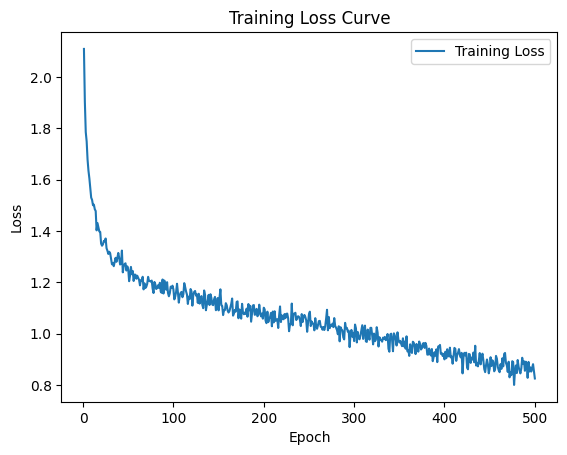

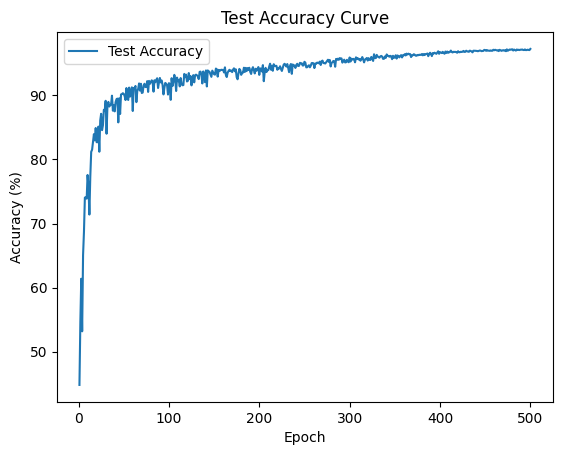

Final Training Loss: 0.825
Final Test Accuracy: 97.26%
Total Trainable Parameters: 4359242


In [6]:
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt

if __name__ == "__main__":
    transform_train = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.AutoAugment(policy=T.AutoAugmentPolicy.CIFAR10),
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        T.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3))
    ])
    transform_test = T.Compose([
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net = PreActSEResNet20().to(device)

    total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print("Total parameters:", total_params)
    if total_params > 5e6:
        print("Our model is too fat and exceeds 5M parameters!")
        exit(1)

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

    num_epochs = 500
    # Learning rate scheduler (cosine annealing)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_loss_per_epoch = []
    test_acc_per_epoch = []
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        epoch_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Mixup/CutMix
            if np.random.rand() < 0.5:
                images, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=1.0)
            else:
                images, targets_a, targets_b, lam = cutmix_data(inputs, targets, alpha=1.0)

            outputs = net(images)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_loss += loss.item()

            if (batch_idx + 1) %50 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}: Loss {running_loss / 50:.3f}")
                running_loss = 0.0

        avg_train_loss = epoch_loss / len(trainloader)
        train_loss_per_epoch.append(avg_train_loss)
        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.3f}")

        net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        test_acc = 100. * correct / total
        test_acc_per_epoch.append(test_acc)
        print(f"Epoch {epoch+1}: Test Accuracy: {test_acc:.2f}%")

        # Step the scheduler each epoch
        scheduler.step()

        if (epoch + 1) % 5 == 0:
            torch.save(net.state_dict(), f'./model_epoch_{epoch+1}.pth')
            print(f"Model saved at epoch {epoch+1}.")

    print("Training finished!")

    plt.figure()
    plt.plot(range(1, num_epochs+1), train_loss_per_epoch, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(range(1, num_epochs+1), test_acc_per_epoch, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Test Accuracy Curve")
    plt.legend()
    plt.show()

    final_train_loss = train_loss_per_epoch[-1]
    final_test_acc = test_acc_per_epoch[-1]

    print(f"Final Training Loss: {final_train_loss:.3f}")
    print(f"Final Test Accuracy: {final_test_acc:.2f}%")
    print(f"Total Trainable Parameters: {total_params}")

In [ ]:
import torch.utils.data as data
import pickle
import pandas as pd
import numpy as np
from PIL import Image
import torch

import torchvision.transforms as T

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = PreActSEResNet20().to(device)
checkpoint_path = 'model.pth'
net.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))
net.eval()

with open('cifar_test_nolabel.pkl', 'rb') as f:
    test_dict = pickle.load(f)

# Extract images and IDs from the dictionary
images = test_dict[b'data']
ids = test_dict[b'ids']

# Check if images need reshaping.
if len(images.shape) == 2 and images.shape[1] == 3072:
    images = images.reshape(-1, 3, 32, 32)
elif len(images.shape) == 3:
    images = np.transpose(images, (0, 3, 1, 2))

test_transform = T.Compose([
    T.ToPILImage(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Create a dataset for the test images using the extracted images
class CIFAR10TestDataset(data.Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get the image as a NumPy array
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        return img

test_dataset = CIFAR10TestDataset(images, transform=test_transform)
test_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# Run inference and collect predictions
all_preds = []
with torch.no_grad():
    for batch_imgs in test_loader:
        batch_imgs = batch_imgs.to(device)
        outputs = net(batch_imgs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())

assert len(all_preds) == len(ids), "Mismatch between predictions and provided IDs!"


df = pd.DataFrame({
    'ID': ids,
    'Label': all_preds
})

# Save to CSV
df.to_csv('prediction.csv', index=False)
print("Submission file 'prediction.csv' generated successfully.")

Submission file 'prediction.csv' generated successfully.


In [1]:
!git config --global user.name "Yog-Sothothe"

In [1]:
!git clone https://github.com/Yog-Sothothe/DL-Project-1.git

Cloning into 'DL-Project-1'...


cp: cannot stat '/content/Copy': No such file or directory
cp: cannot stat 'of': No such file or directory
cp: cannot stat 'Untitled9.ipynb': No such file or directory
